In [140]:
import pandas as pd
import numpy as np
import cv2 as cv

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import os
import fnmatch
import matplotlib.pyplot as plt
from PIL import Image
import re

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from imgaug import augmenters as img_aug

import random

In [141]:
image_paths = []
steering_angles = []
pattern = "*.jpg"


steering_angles_dir = "C:/Users/Warrior911/Desktop/FYP/Practice/"
columns = ["img_path", "steering_angles"]
data = pd.read_csv(os.path.join(steering_angles_dir, "img_data.csv"), names = columns)


lane_image_dir = "C:/Users/Warrior911/Desktop/FYP/Practice/Lane_Images/"
lane_image_list = os.listdir(lane_image_dir)

#sorting images by ascending order
lane_image_list.sort(key=lambda f: int(re.sub('\D', '', f)))

In [142]:
for filename in lane_image_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(lane_image_dir, filename))
        
for steering_angle in data["steering_angles"]:
    angle = steering_angle
    steering_angles.append(angle)

print(len(steering_angles))
print(len(image_paths))

1118
1118


image_path:  C:/Users/Warrior911/Desktop/FYP/Practice/Lane_Images/img_56.jpg
steering_Angle:  66


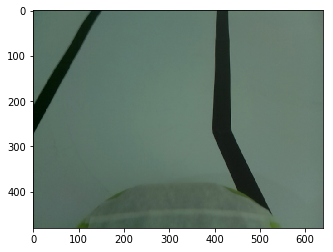

In [143]:
image_index = 55
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: ", image_paths[image_index] )
print("steering_Angle: ", steering_angles[image_index] )

df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Steering_angle'] = steering_angles

(array([  6.,  41.,  58.,  45.,  66.,  44.,  49.,  22.,  25., 108., 128.,
         94.,  73.,  83., 100.,  72.,  57.,  36.,   8.,   3.]),
 array([ 48.  ,  52.15,  56.3 ,  60.45,  64.6 ,  68.75,  72.9 ,  77.05,
         81.2 ,  85.35,  89.5 ,  93.65,  97.8 , 101.95, 106.1 , 110.25,
        114.4 , 118.55, 122.7 , 126.85, 131.  ]),
 <a list of 20 Patch objects>)

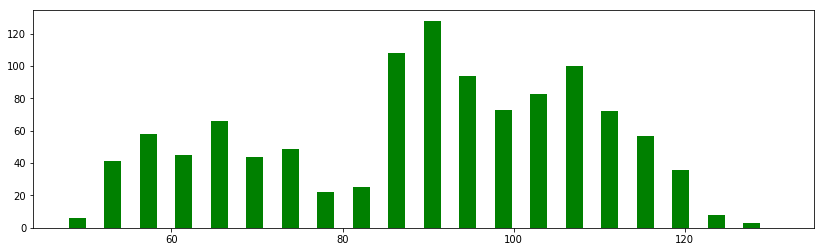

In [144]:
# Analyzing the distribution of steering angles
num_of_bins = 20
samples_per_bin = 100
hist, bins = np.histogram(df['Steering_angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(14,4))
axes.hist(df['Steering_angle'], bins=num_of_bins, width=2, color='green')

Training data:  894
Validation data:  224


Text(0.5, 1.0, 'Validation Data')

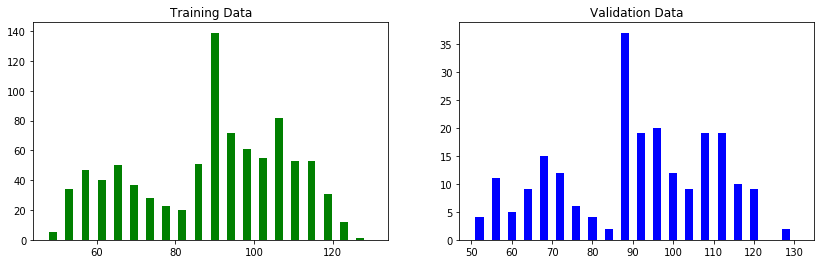

In [145]:
x_train, x_valid, y_train, y_valid = train_test_split(image_paths, steering_angles, test_size=0.2)
print("Training data: ", len(x_train))
print("Validation data: ", len(x_valid))

# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(14,4))
axes[0].hist(y_train, bins=num_of_bins, width=2, color='green')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=2, color='blue')
axes[1].set_title('Validation Data')

Text(0.5, 1.0, 'Zoomed Image')

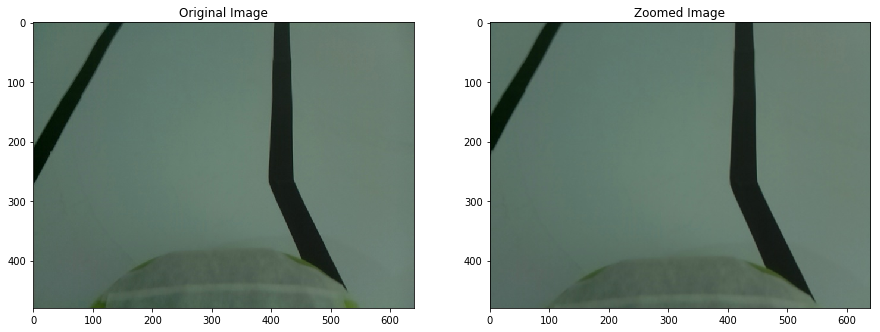

In [146]:
#Read Image as RGB, default is BGR from OpenCV
def read_image(image_path):
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

#Zoom Image by 30%
def zoom(img):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% to 130%
    img = zoom.augment_image(img)
    return img

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = read_image(image_paths[image_index])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("Original Image")
axes[1].imshow(image_zoom)
axes[1].set_title("Zoomed Image")

Text(0.5, 1.0, 'Brightness Changed')

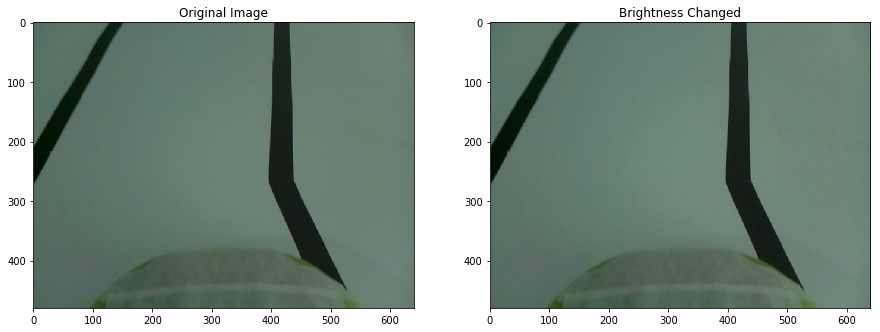

In [147]:
#Changing the Brightness of the Image
def change_brightness(image):
    brightness = img_aug.Multiply((0.7, 1.3)) # increase or decrease brightness by 30%
    image = brightness.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
img_orig = read_image(image_paths[image_index])
img_brightness = change_brightness(image_orig)
axes[0].imshow(img_orig)
axes[0].set_title("Original Image")
axes[1].imshow(img_brightness)
axes[1].set_title("Brightness Changed")

Text(0.5, 1.0, 'Panned Image')

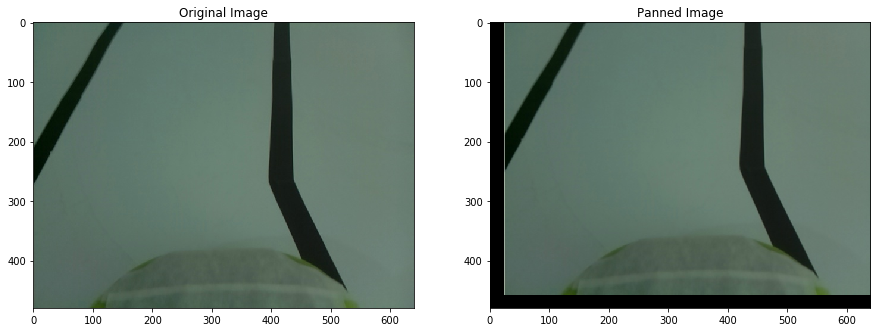

In [148]:
#Pan the Image from random direction (up, down, right, left) by 10%
def pan(img):
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    img = pan.augment_image(img)
    return img

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
img_orig = read_image(image_paths[image_index])
img_pan = pan(img_orig)
axes[0].imshow(img_orig)
axes[0].set_title("Original Image")
axes[1].imshow(img_pan)
axes[1].set_title("Panned Image")

Text(0.5, 1.0, 'Blurred Image')

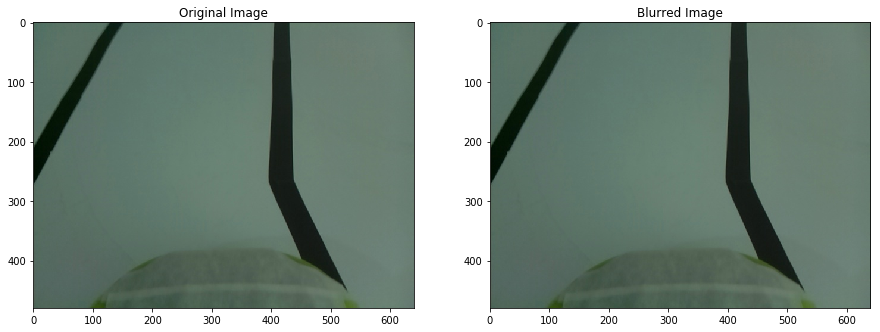

In [160]:
#Bluring Image
def blur(img):
    kernel_size = random.randint(1, 5)  #Any kernel size greater than 5 would make the image too much blurry
    img = cv.blur(img, (kernel_size, kernel_size))
    return img

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
img_orig = read_image(image_paths[image_index])
img_blur = blur(img_orig)
axes[0].imshow(img_orig)
axes[0].set_title("Original Image")
axes[1].imshow(img_blur)
axes[1].set_title("Blurred Image")

Text(0.5, 1.0, 'Flipped Angle=114')

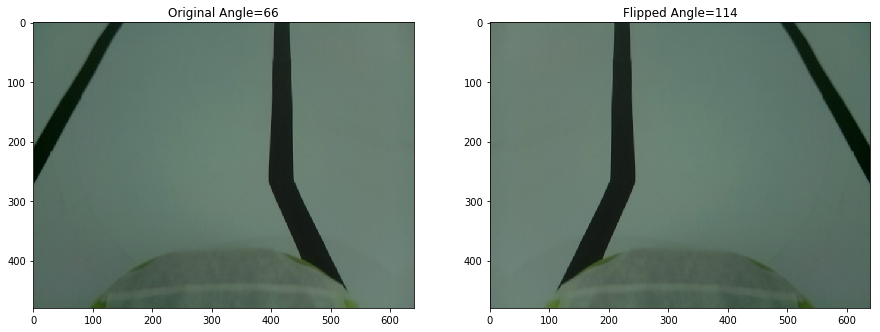

In [150]:
#Flip Image Horizontally as well as Steering Angle
def random_flip(img, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1: #random flip
        img = cv.flip(img, 1)
        steering_angle = 180 - steering_angle   
    return img, steering_angle

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
img_orig = read_image(image_paths[image_index])
img_flip, steering_angle = random_flip(img_orig, steering_angles[image_index])
axes[0].imshow(img_orig)
axes[0].set_title("Original Angle=%s" % steering_angles[image_index])
axes[1].imshow(img_flip)
axes[1].set_title("Flipped Angle=%s" % steering_angle)

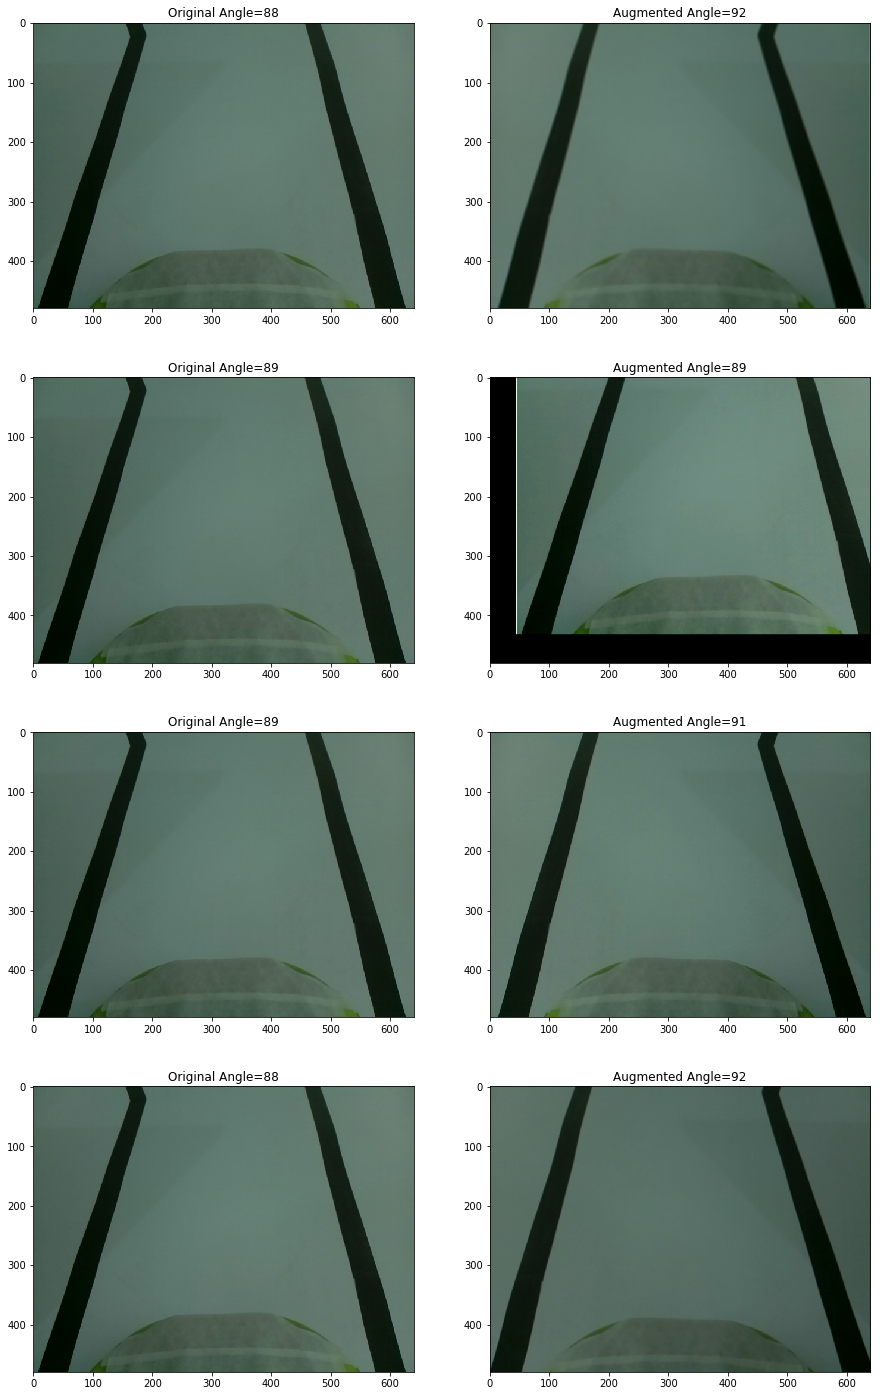

In [151]:
def random_augment(img, steering_angle):
    if np.random.rand() < 0.5:
        img = zoom(img)
    if np.random.rand() < 0.5:
        img = pan(img)
    if np.random.rand() < 0.5:
        img = blur(img)
    if np.random.rand() < 0.5:
        img = change_brightness(img)
    img, steering_angle = random_flip(img, steering_angle)
    
    return img, steering_angle

# show a few randomly augmented images
ncol = 2
nrow = 4
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 25))

for i in range(nrow):
    rand_index = i #random.randint(0, len(image_paths) - 1)
    img_path = image_paths[rand_index]
    steering_angle_orig = steering_angles[rand_index]
    
    img_orig = read_image(img_path)
    img_augmented, steering_angle_aug = random_augment(img_orig, steering_angle_orig)
    
    axes[i][0].imshow(img_orig)
    axes[i][0].set_title("Original Angle=%s" % steering_angle_orig)
    axes[i][1].imshow(img_augmented)
    axes[i][1].set_title("Augmented Angle=%s" % steering_angle_aug)

Text(0.5, 1.0, 'Processed Image')

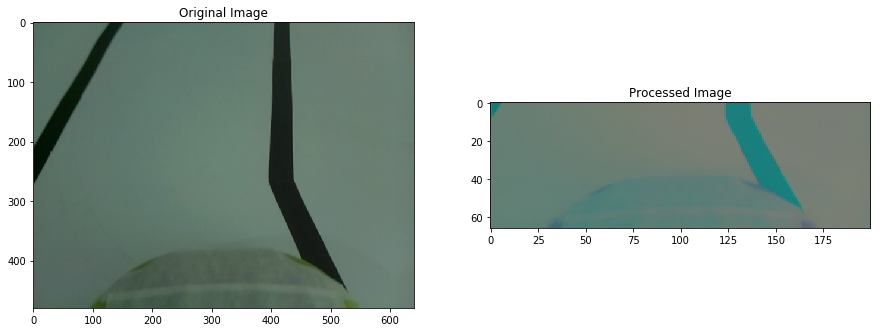

In [152]:
def img_preprocess(img):
    height, width, _ = img.shape
    img = img[int(height/2):,:,:]  # removing the top half of the image, as it is not relavant for lane detection
    img = cv.cvtColor(img, cv.COLOR_RGB2YUV)  # Nvidia model claims it's best to use YUV color space, so we will use YUV
    img = cv.GaussianBlur(img, (3,3), 0)
    img = cv.resize(img, (200,66)) # input image size for the Nvidia Model is (200,66)
    img = img / 255 # normalizing the image
    return img

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
img_orig = read_image(image_paths[image_index])
img_processed = img_preprocess(img_orig)
axes[0].imshow(img_orig)
axes[0].set_title("Original Image")
axes[1].imshow(img_processed)
axes[1].set_title("Processed Image")

In [155]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, we will use elu instead of Relu due to the dead Relu problem
    # We will skip the 1st hiddel layer which is normalization layer, as we have normalized our data
    
    # Convolutional Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # this layer is not in the original model added to address overfitting
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # this layer is not in the original model added to address overfitting
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # Since this is a regression problem rather than a classification problem,
    # we will use MSE (Mean Squared Error) as our loss function
    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [156]:
model = nvidia_model()
print(model.summary())
# we will have 252,219 trainable parameters

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [162]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            rand_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[rand_index]
            img = read_image(image_paths[rand_index])
            steering_angle = steering_angles[rand_index]
            
            if is_training:
                img, steering_angle = random_augment(img, steering_angle)
              
            img = img_preprocess(img)
            batch_images.append(img)
            batch_steering_angles.append(steering_angle)
            
        yield(np.asarray(batch_images), np.asarray(batch_steering_angles))

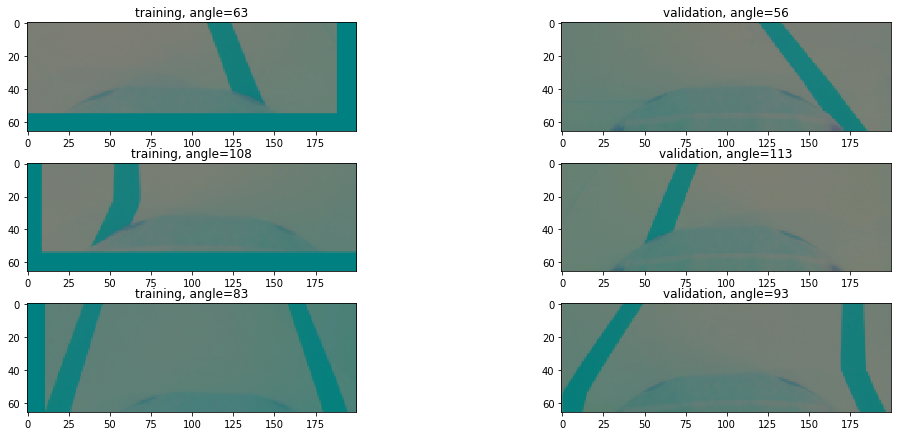

In [164]:
ncol = 2
nrow = 3

x_train_batch, y_train_batch = next(image_data_generator(x_train, y_train, nrow, True))
x_valid_batch, y_valid_batch = next(image_data_generator(x_valid, y_valid, nrow, False))


fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(x_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(x_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

In [ ]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir,'lane_navigation_checkpoint.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_data_generator(x_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=300,
                              epochs=1,
                              validation_data = image_data_generator(x_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks = [checkpoint_callback])

model.save(os.path.join(output_dir,'lane_navigation_final_model.h5'))

